# Charmi Patel

# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [1]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()
np.shape(hosts)

(9,)

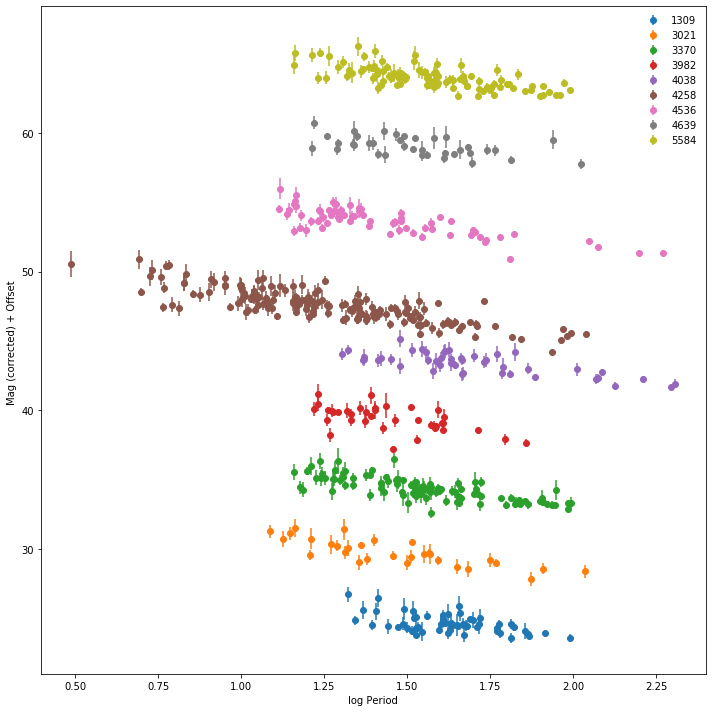

In [2]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period error (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


In [3]:
data = ceph.data
#data[0,:]

# i = 0 : Id
# i = 1 : field (table 2)
# i = 2 : F 160 W (mag, table 2) - can be pulled from the class
# i = 3 : sigma (mag, table 2) - can be pulled from the class
# i = 4 : log(P) (days, table 2) - can be pulled from the class
# i = 5 : b (table 4)
# i = 6 : bais (mag , table 2)


Equation 1: Model
>$m_{W{_i,_j}}$ = ($\mu_{0,i} - \mu_{0, 4258}$) + $zp{_W,_{4258}}$ + $b_{W}log (P_{i,j})$

the Maximum likelihood function says: 

>$ \ln L(a, b) = constant - \frac{1}{2 \sigma^2} \sum_{i=1}^N (y_i - M(x_i))^2 $

In our case, this will become:

>$ \ln L(b_{W},zp{_W,_{4258}}) = constant - \frac{1}{2 \sigma_{int}^2} \sum_{i,j} (M_{w_{i,j}} - M(\mu_{0,i},\mu_{0, 4258},zp{_W,_{4258}},b_{W},log (P_{i,j})))^2 $

>$ -\ln L(b_{W},zp{_W,_{4258}}) = \frac{1}{2 \sigma_{int}^2} \sum_{i,j} (m_{obs}  - model(\mu_{0,i},\mu_{0, 4258},zp{_W,_{4258}},b_{W},log (P_{i,j})))^2 $

>$ -\ln L(b_{W},zp{_W,_{4258}}) = \frac{1}{2 \sigma_{int}^2} \sum_{i,j} (m_{obs}  - (b_{W}log (P_{i,j}) + zp{_W,_{4258}} + (\mu_{0,i} - \mu_{0, 4258}) )))^2 $

This is consistant with the negative_log_likelihood function in ceph where slope(m) = $b_{W}$ and y-intercept(b) = $zp{_W,_{4258}} + (\mu_{0,i} - \mu_{0, 4258})$ !!✅

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

There are two parameters in the given linear model:

1) $ slope, m  = b_{w}$ --- given the data we see in the plot above, there a general downwards trend in the P-L plot. This means that the slope is negetive. Thus, the range of the slope is about -20< m <0
   
2) $ y-intercept, b =  zp{_W,_{4258}} + (\mu_{0,i} - \mu_{0, 4258}) $ --- there are technically two free parameters encompassed in the y-interecept. zp is the absolute distance of each galaxy so it has to be >0 and $\Delta{\mu}$ is reddening-free distances for the hosts galaxies relative to NGC 4258 which also has to be >0. That combined with guesses from the plot above, the range for y-intercept should be 20 < b < 30

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [4]:
#import statments 
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.optimize import minimize


In [5]:
# Implement this likelihood and prior in python
    # mu_0i - redding free distance: will be different for different cefeids
    # mu_04258 - redding free distancs from 0458
    # zp_4258 intercept of P-L relation fit to cepheids of 4258
    # b_w and zp_w4258 are nuisance parameters

#STEP 1: THE MODEL FUNCTION:
def model(logP, bw ,b):
    # y = mx + b 
    mag = bw*logP + b
    return mag


#STEP 2: LIKELIHOOD FUNCTION:
def chisquared_func(free_params, logP, m_obs, sigma_mag):
    b_w, b = free_params
    diff = m_obs - model(logP, b_w ,b)
    chisquared = np.sum((diff/sigma_mag)**2)
    return chisquared
    
def log_likelihood_func(free_params,  logP, m_obs, sigma_mag):   
    likelihood = 0.5 * chisquared_func(free_params, logP, m_obs, sigma_mag)
    return -likelihood

#STEP 3: PRIOR FUNCTION:
def log_prior(free_params):
    b_w, b = free_params
    if -5.0 < b_w < 0 and 25.0 < b < 30.0:
        return 0.0
    return -np.inf

def log_probability(free_params, logP, m_obs, sigma_mag):
    lp = log_prior(free_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_func(free_params,  logP, m_obs, sigma_mag)


100%|██████████| 5000/5000 [00:07<00:00, 637.28it/s]


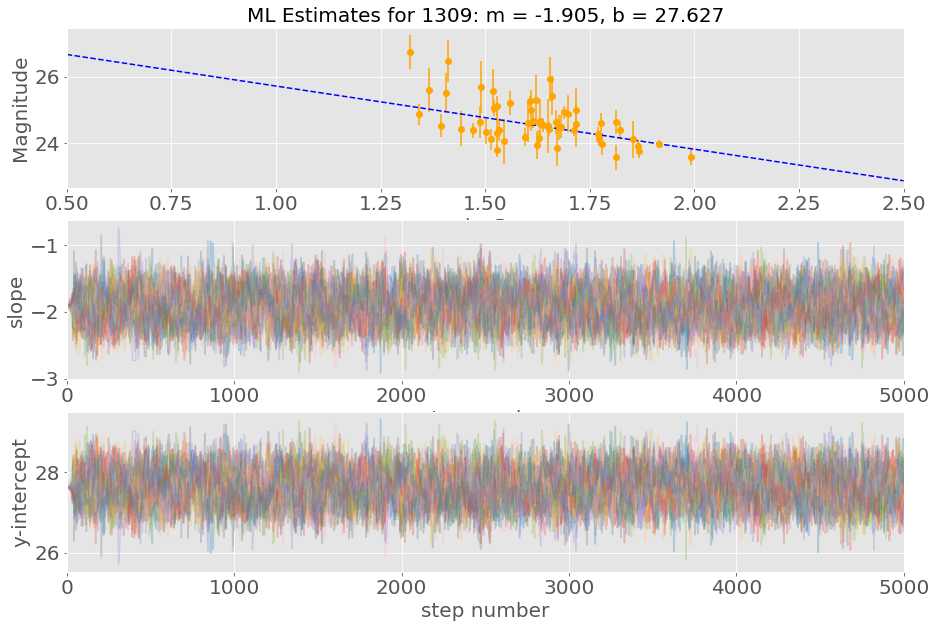

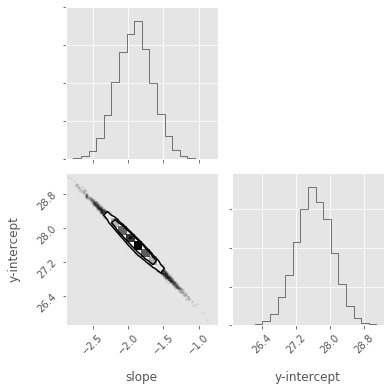

100%|██████████| 5000/5000 [00:08<00:00, 579.84it/s]


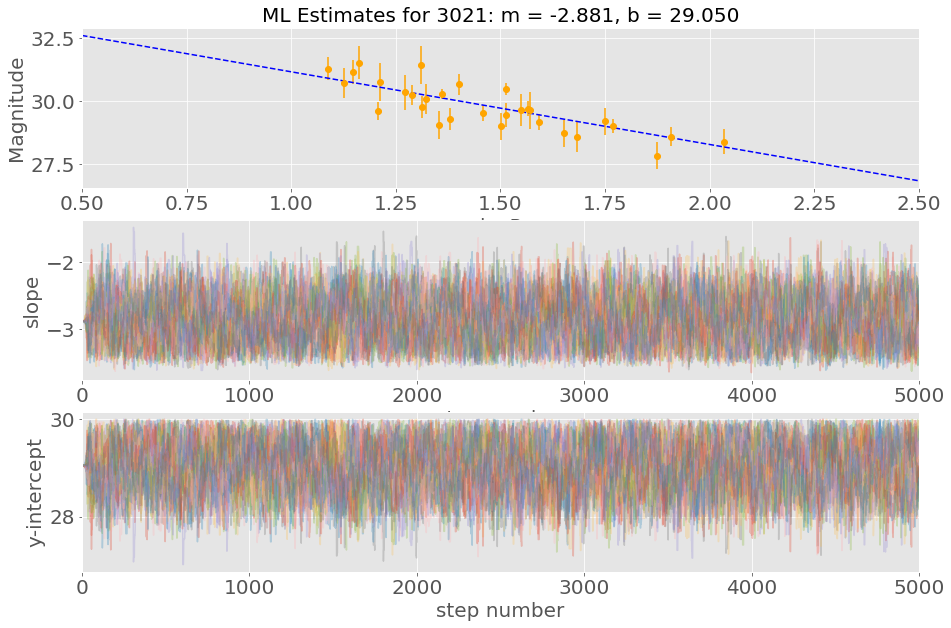

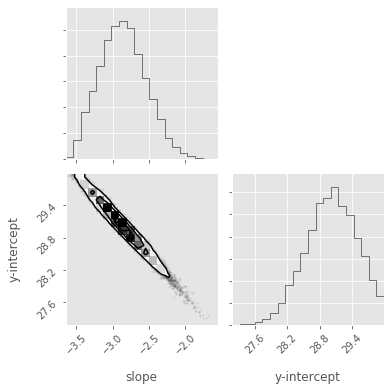

100%|██████████| 5000/5000 [00:08<00:00, 605.05it/s]


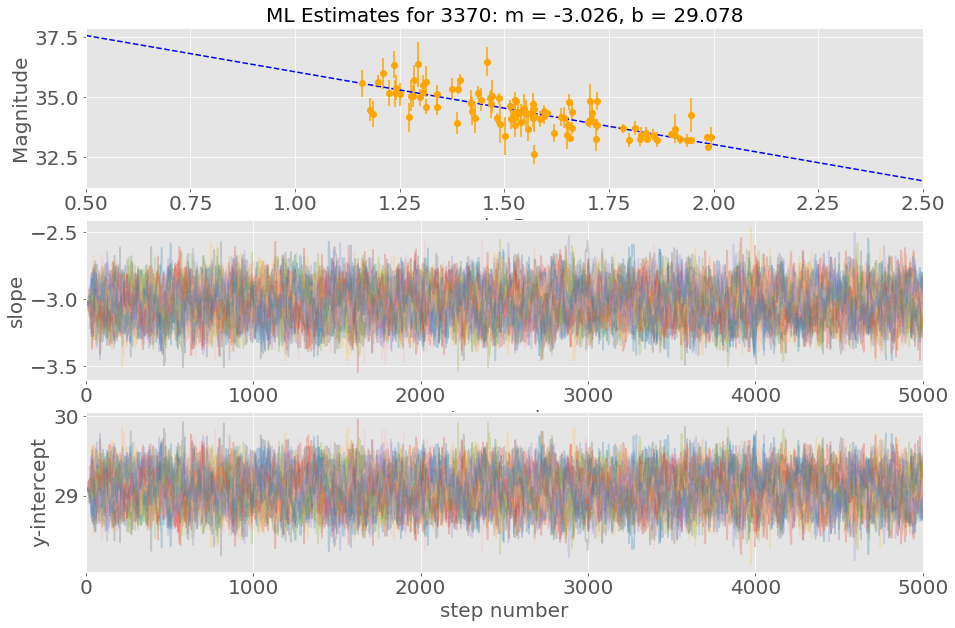

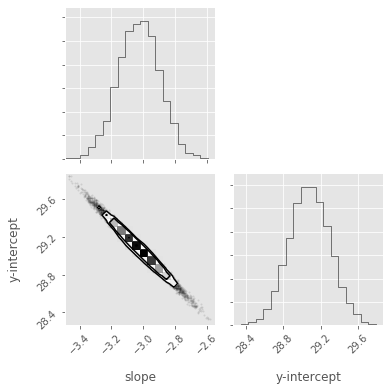

100%|██████████| 5000/5000 [00:13<00:00, 380.13it/s]


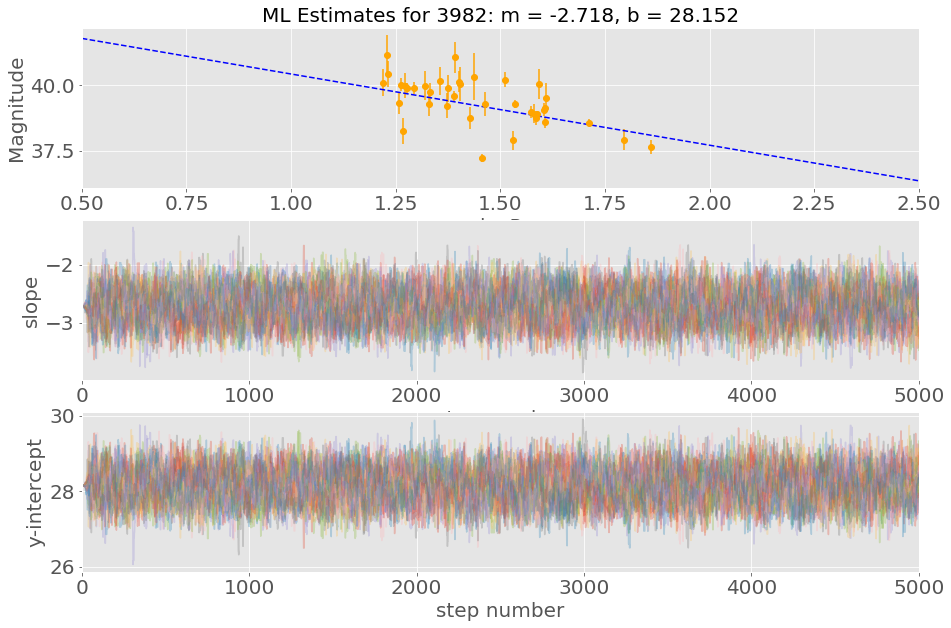

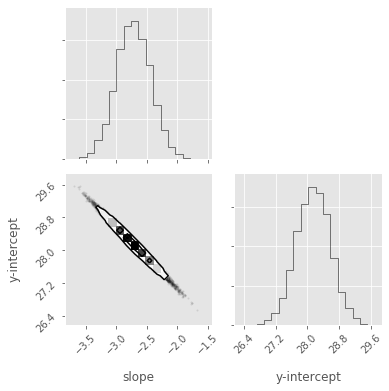

100%|██████████| 5000/5000 [00:11<00:00, 452.92it/s]


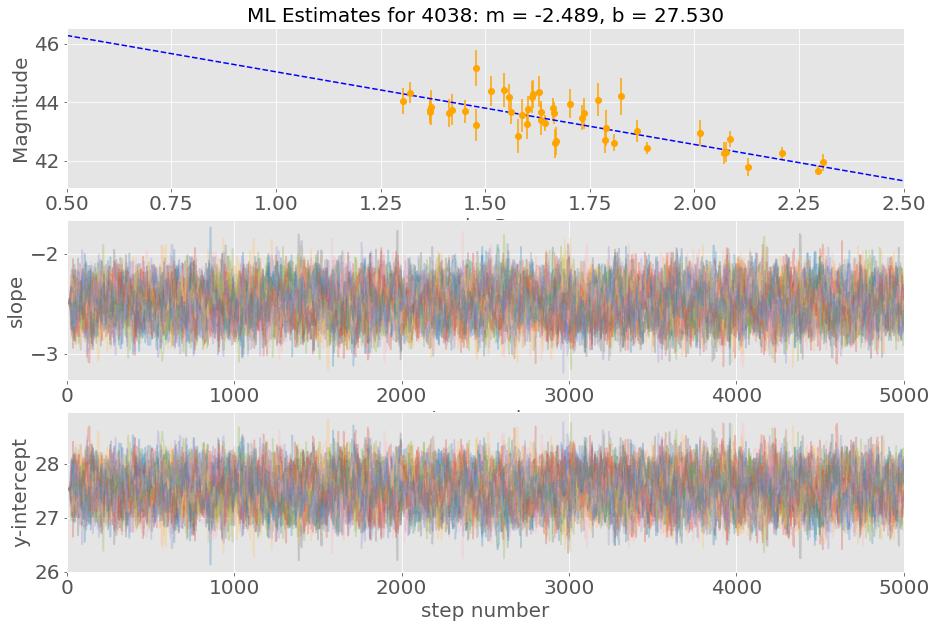

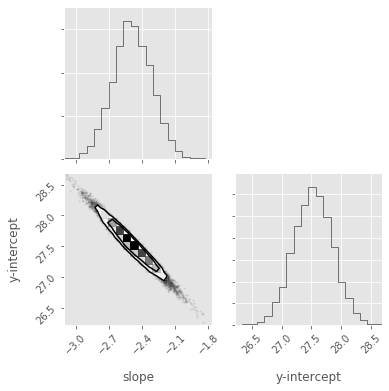

100%|██████████| 5000/5000 [00:08<00:00, 568.24it/s]


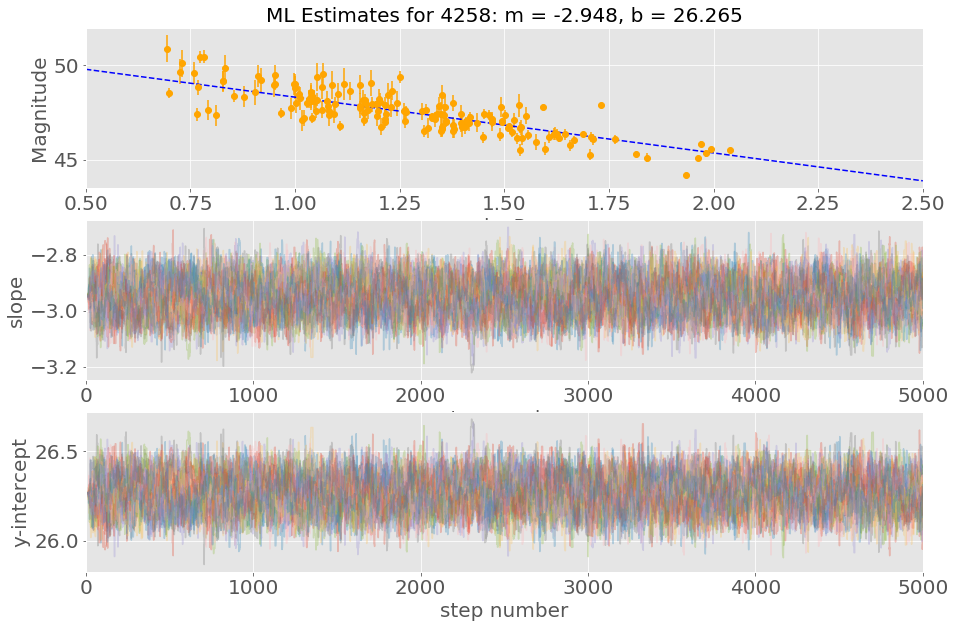

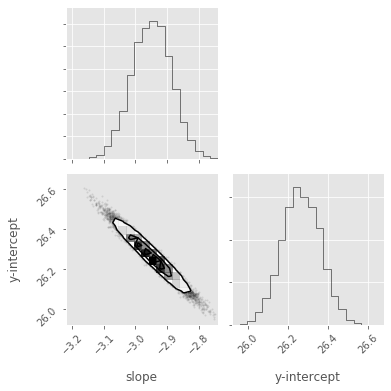

100%|██████████| 5000/5000 [00:08<00:00, 607.82it/s]


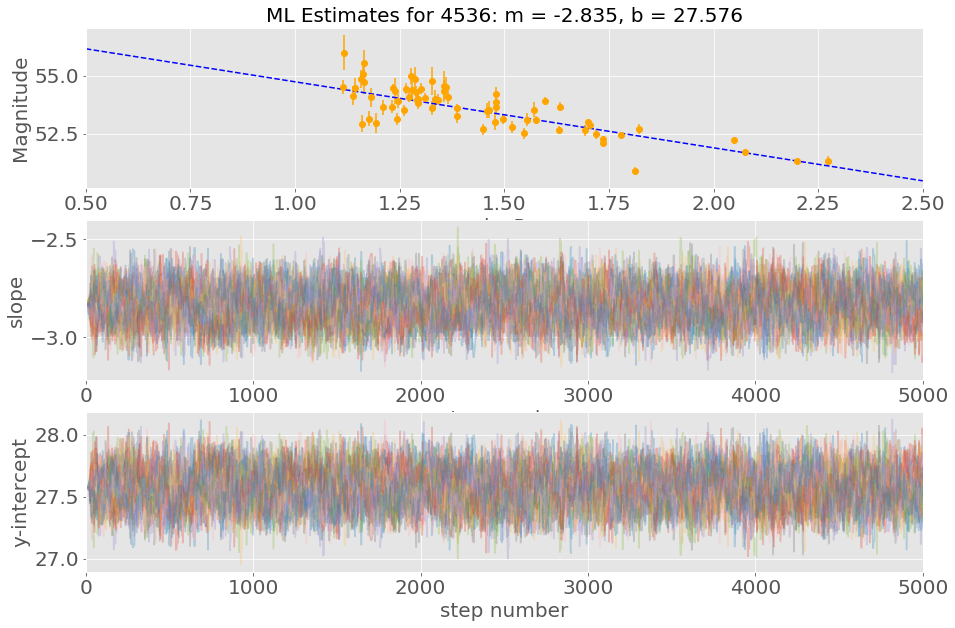

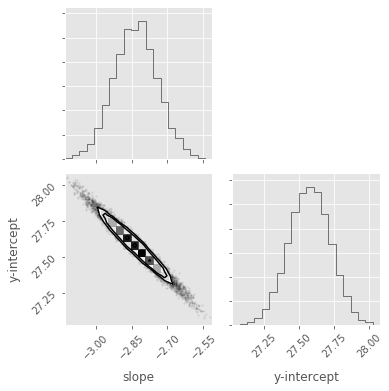

100%|██████████| 5000/5000 [00:08<00:00, 613.67it/s]


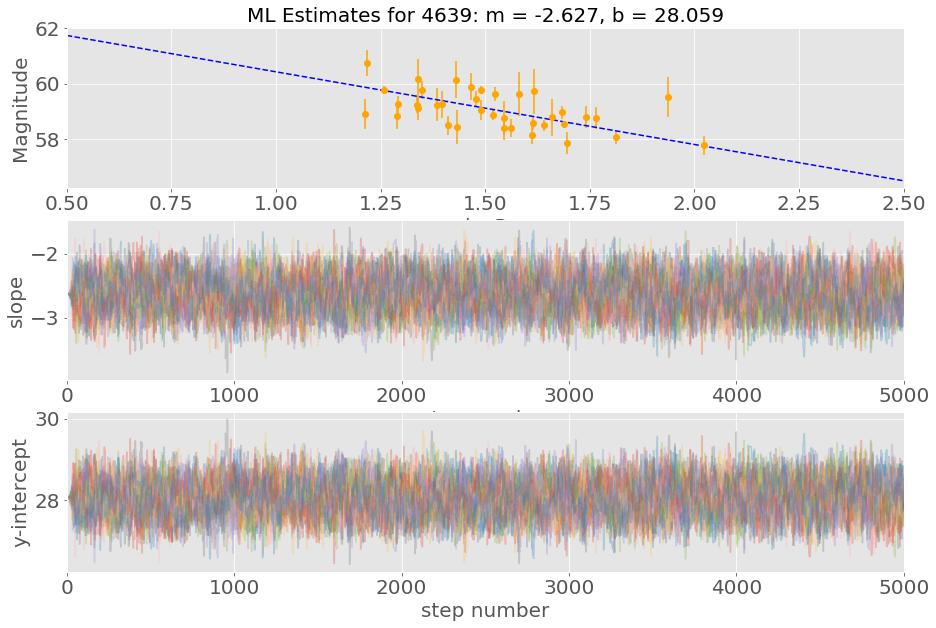

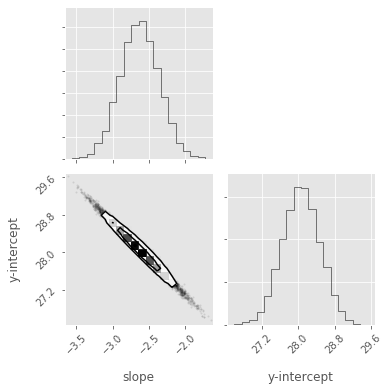

100%|██████████| 5000/5000 [00:13<00:00, 372.78it/s]


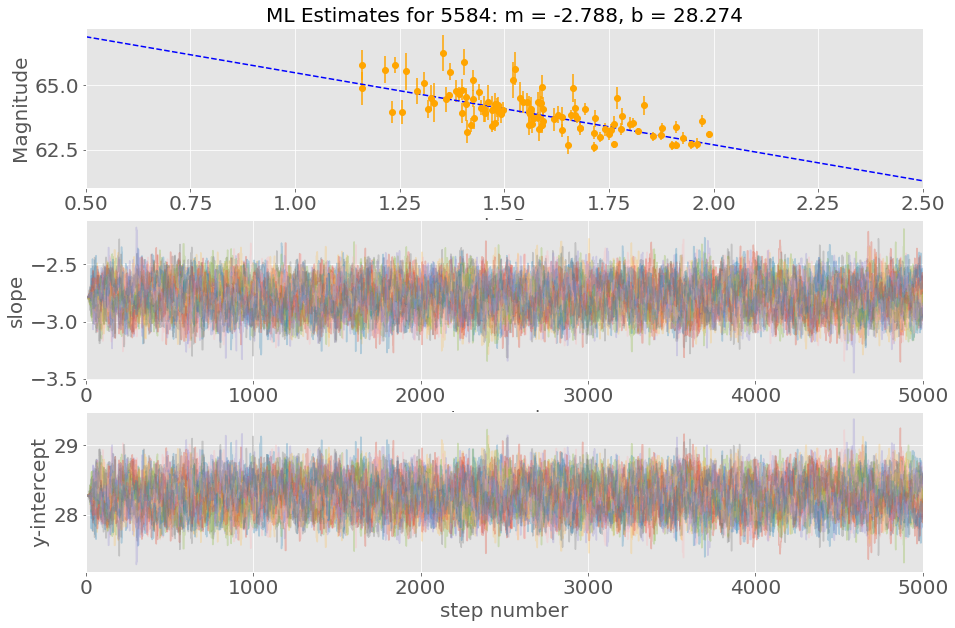

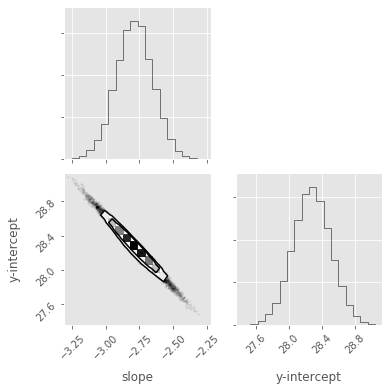

In [6]:
plot_logP = np.linspace(0.5, 2.5, num = 100)
plt.style.use("ggplot")

fitted_data = {}
for i, ID in enumerate(hosts):    
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    guesses = np.array([-10, 30.]) 
    solution = minimize(chisquared_func, guesses, args=(logP, mobs, sigma_obs))
    bw_ml, b_ml = solution.x
    
    fitted_data[ID] = solution.x
    pos = solution.x + 1e-4 * np.random.randn(32, 2)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(logP, mobs, sigma_obs))
    sampler.run_mcmc(pos, 5000, progress=True)
    samples = sampler.get_chain()
    
    
    fig, ((ax1), (ax2), (ax3)) = plt.subplots(3,1, figsize=(15, 10))
    ax1.set_title("ML Estimates for %s: m = %.3f, b = %.3f" % (ID, bw_ml, b_ml), size = 20)
    ax1.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', color = "orange", marker='o', label=ID)
    ax1.plot(plot_logP, (5*i)+model(plot_logP, bw_ml, b_ml),linestyle='--',color='blue')
    ax1.set_xlabel("logP", size = 20)
    ax1.set_ylabel("Magnitude", size = 20)
    ax1.set_xlim(0.5,2.5)
    ax1.tick_params("both", labelsize = 20)

    
    ax2.plot(samples[:, :, 0], alpha=0.3)
    ax2.set_xlim(0, len(samples))
    ax2.set_ylabel("slope",  size = 20)
    ax2.set_xlabel("step number", size = 20)
    ax2.tick_params("both", labelsize = 20)
    
    
    ax3.plot(samples[:, :, 1], alpha=0.3)
    ax3.set_xlim(0, len(samples))
    ax3.set_xlabel("step number", size = 20)
    ax3.set_ylabel("y-intercept",  size = 20)
    ax3.tick_params("both", labelsize = 20)
    
    labels = ["slope", "y-intercept"]
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    fig = corner.corner(flat_samples, labels = labels)
    
    plt.tight_layout()
    plt.show()
    
fig.tight_layout()

In [7]:
fitted_data

{'1309': array([-1.90530727, 27.62680267]),
 '3021': array([-2.88122632, 29.04952014]),
 '3370': array([-3.02592294, 29.07767608]),
 '3982': array([-2.71848369, 28.15185835]),
 '4038': array([-2.48918851, 27.52960846]),
 '4258': array([-2.94832738, 26.26490167]),
 '4536': array([-2.83478729, 27.57568304]),
 '4639': array([-2.62746833, 28.05924204]),
 '5584': array([-2.78757569, 28.27428385])}

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

Equation 3: 
>$m^{0}_{v,i} = (\mu_{0,i} - \mu_{0,4258}) +m^{0}_{v,4258}$

Equation 3 rearranged: 
>$m^{0}_{v,4258} - \mu_{0,4258}  = m^{0}_{v,i} - \mu_{0,i} $

Equation 4: 
>$ \log{H_0} =\frac{(m^{0}_{v,4258} - \mu_{v,4258}) + 5a_v+ 25}{5} $  

substitue rearranged Equation 3:
>$  \log{H_0} =\frac{m^{0}_{v,i} - \mu_{v,i} + 5a_v+ 25}{5}$ 

>$\log{H_0} =\frac{m^{0}_{v,i} - \mu_{v,i} + \mu_{v,4258}  -  \mu_{v,4258}  + 5a_v+ 25}{5} $

>$\log{H_0} =\frac{(m^{0}_{v,i} + 5a_v) - (\mu_{v,i} - \mu_{v,4258})  -  \mu_{v,4258}  + 25}{5} $

>$ {H_0} =10^{\frac{(m^{0}_{v,i} + 5a_v) - (\mu_{v,i} - \mu_{v,4258})  -  \mu_{v,4258}  + 25}{5}  } $



# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

In [12]:
zp_0_4258 = fitted_data['4258'][1]
fitted_del_mu = np.asarray([y-zp_0_4258 for x,y in fitted_data.values()])
fitted_del_mu = fitted_del_mu[fitted_del_mu!=0]

In [13]:
m_a = np.asarray([16.768, 16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274])
Hdist_4258 = 7.6e6

In [16]:
dist_mod = 5*np.log10(Hdist_4258/10)
H0 = 10**(((m_a) - (fitted_del_mu) - dist_mod + 25) / 5)

print("Distance Modulus:",dist_mod)
print("My H0 value is %.3f ± %.3f km/s/Mpc" %(np.mean(H0),np.std(H0)))

Distance Modulus: 29.404067961403957
My H0 value is 96.555 ± 26.010 km/s/Mpc
